In [1]:
import os
import re
import numpy as np
import random as rn
import keras
import tensorflow as tf
from keras import backend as K    
from keras.models import Model
from keras.layers import (
    Conv2D,
    MaxPooling2D,
    ZeroPadding2D,
)
from sklearn.preprocessing import LabelBinarizer
from keras.layers.normalization import BatchNormalization
from keras.initializers import he_normal

from keras import optimizers
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from sklearn.metrics import accuracy_score, f1_score
import vgg_19
import scipy.io

Using TensorFlow backend.


## Parameters

In [2]:
batch_size        = 32
num_classes       = 101
epochs            = 50
weight_decay      = 0.01
steps_per_epoch   = 9146 / batch_size
log_filepath      = '/tmp/caltech101/vgg19'
dropout           = 0.5
image_input_shape = (224, 224, 3,)
train_data_dir    = 'data/101_ObjectCategories/train'
val_data_dir      = 'data/101_ObjectCategories/val'
annotation_dir    = 'data/101_Annotations'

## Loading the data

In [3]:
catagories = os.listdir('data/101_ObjectCategories/train')
catagories_one_hot = LabelBinarizer().fit_transform(catagories)

## VGG 19 Model

In [4]:
vgg19_model = vgg_19.build_vgg19_model(image_input_shape, num_classes, dropout, weight_decay)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [5]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=1e-6)
vgg19_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['acc'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
tb_cb = TensorBoard(log_dir=os.path.join(os.path.join(log_filepath, 'v199_anno'), 'model_vgg_19'))

In [7]:
mean = [103.939, 116.779, 123.68]
def prep_image(im):    
    # Convert to BGR
    im = im[:,:, ::-1]
    im[..., 0] -= mean[0]
    im[..., 1] -= mean[1]
    im[..., 2] -= mean[2]
    return im

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=prep_image,
    rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=image_input_shape[:-1],
        batch_size=batch_size,
        class_mode='categorical')
val_datagen = ImageDataGenerator(
    preprocessing_function=prep_image,
    rescale=1./255)
val_generator = train_datagen.flow_from_directory(
        val_data_dir,
        target_size=image_input_shape[:-1],
        batch_size=batch_size,
        shuffle=False,   # Important to set to False in order to print falsely classified images
        class_mode='categorical')


Found 7414 images belonging to 101 classes.
Found 1263 images belonging to 101 classes.


In [9]:
vgg19_model.fit_generator(
    train_generator, epochs=epochs, 
    validation_data=val_generator,
    steps_per_epoch=steps_per_epoch, 
    callbacks=[tb_cb], 
    max_queue_size=100
)

Epoch 1/50
286/285 [==============================] - 189s 662ms/step - loss: 4.9489 - acc: 0.1779 - val_loss: 5.0818 - val_acc: 0.2201
Epoch 2/50
286/285 [==============================] - 185s 646ms/step - loss: 3.9841 - acc: 0.2710 - val_loss: 3.6590 - val_acc: 0.3135
Epoch 3/50
286/285 [==============================] - 179s 624ms/step - loss: 3.5655 - acc: 0.3057 - val_loss: 3.4711 - val_acc: 0.3262
Epoch 4/50
286/285 [==============================] - 179s 625ms/step - loss: 3.3040 - acc: 0.3256 - val_loss: 3.4799 - val_acc: 0.2930
Epoch 5/50
286/285 [==============================] - 179s 624ms/step - loss: 3.0849 - acc: 0.3517 - val_loss: 3.1347 - val_acc: 0.3484
Epoch 6/50
286/285 [==============================] - 178s 624ms/step - loss: 2.8955 - acc: 0.3741 - val_loss: 3.7248 - val_acc: 0.2740
Epoch 7/50
286/285 [==============================] - 179s 624ms/step - loss: 2.7844 - acc: 0.3943 - val_loss: 3.1853 - val_acc: 0.3341
Epoch 8/50
286/285 [============================

### Save the model for further reuse

In [10]:
vgg19_model.save('model_vgg19_snapshot.h5')

### Analyse the results

In [11]:
v19_results = vgg19_model.predict_generator(val_generator)
v19_predicted = v19_results.argmax(axis=-1)
actual = val_generator.classes
key_to_label = {v: k for k, v in val_generator.class_indices.items()}

In [26]:
incorrect_indexes = np.nonzero(v19_predicted != actual)[0]

In [27]:
print('Total {0} incorrectly classified images out of {1}'.format(len(incorrect_indexes), len(v19_results)))
print('Accuracy: {0}'.format(accuracy_score(actual, v19_predicted)))
print('f1 score: {0}'.format(f1_score(actual, v19_predicted, average='weighted')))

Total 304 incorrectly classified images out of 1263
Accuracy: 0.7593032462391133
f1 score: 0.7589623034794661


/home/lihan/.virtualenvs/tf/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Plot incorrectly classificed images

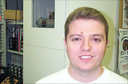

Predicted: Faces_easy
Actual   : Faces


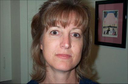

Predicted: Faces_easy
Actual   : Faces


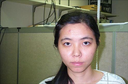

Predicted: Faces_easy
Actual   : Faces


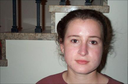

Predicted: Faces
Actual   : Faces_easy


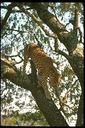

Predicted: wild_cat
Actual   : Leopards


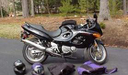

Predicted: pigeon
Actual   : Motorbikes


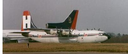

Predicted: chandelier
Actual   : airplanes


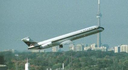

Predicted: helicopter
Actual   : airplanes


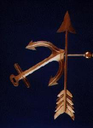

Predicted: grand_piano
Actual   : anchor


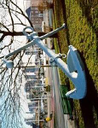

Predicted: cannon
Actual   : anchor


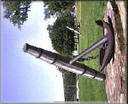

Predicted: mayfly
Actual   : anchor


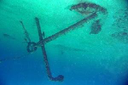

Predicted: dolphin
Actual   : anchor


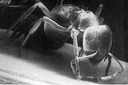

Predicted: mayfly
Actual   : ant


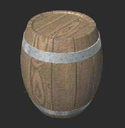

Predicted: nautilus
Actual   : barrel


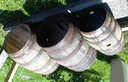

Predicted: pyramid
Actual   : barrel


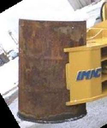

Predicted: llama
Actual   : barrel


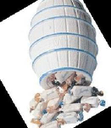

Predicted: pigeon
Actual   : barrel


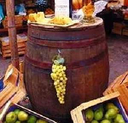

Predicted: okapi
Actual   : barrel


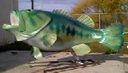

Predicted: water_lilly
Actual   : bass


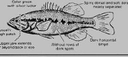

Predicted: cannon
Actual   : bass


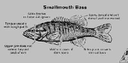

Predicted: hawksbill
Actual   : bass


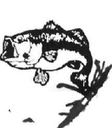

Predicted: electric_guitar
Actual   : bass


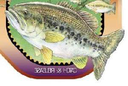

Predicted: crocodile_head
Actual   : bass


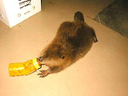

Predicted: platypus
Actual   : beaver


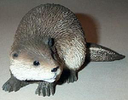

Predicted: hedgehog
Actual   : beaver


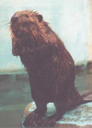

Predicted: elephant
Actual   : beaver


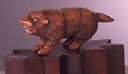

Predicted: Faces
Actual   : beaver


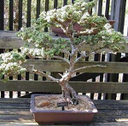

Predicted: laptop
Actual   : bonsai


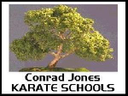

Predicted: accordion
Actual   : bonsai


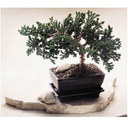

Predicted: wild_cat
Actual   : bonsai


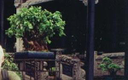

Predicted: bass
Actual   : bonsai


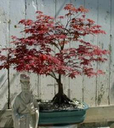

Predicted: bass
Actual   : bonsai


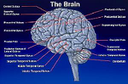

Predicted: nautilus
Actual   : brain


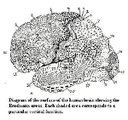

Predicted: hedgehog
Actual   : brain


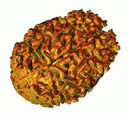

Predicted: pizza
Actual   : brain


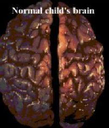

Predicted: cougar_body
Actual   : brain


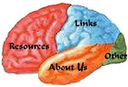

Predicted: lobster
Actual   : brain


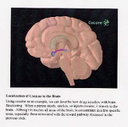

Predicted: airplanes
Actual   : brain


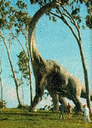

Predicted: umbrella
Actual   : brontosaurus


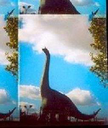

Predicted: Faces
Actual   : brontosaurus


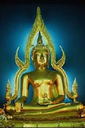

Predicted: ferry
Actual   : buddha


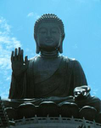

Predicted: stapler
Actual   : buddha


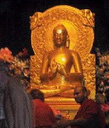

Predicted: sea_horse
Actual   : buddha


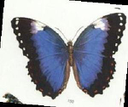

Predicted: soccer_ball
Actual   : butterfly


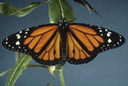

Predicted: watch
Actual   : butterfly


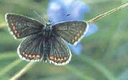

Predicted: hawksbill
Actual   : butterfly


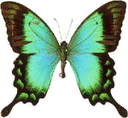

Predicted: dragonfly
Actual   : butterfly


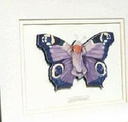

Predicted: revolver
Actual   : butterfly


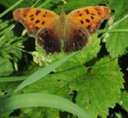

Predicted: crocodile_head
Actual   : butterfly


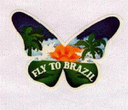

Predicted: Motorbikes
Actual   : butterfly


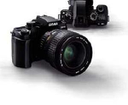

Predicted: Motorbikes
Actual   : camera


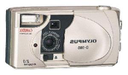

Predicted: cup
Actual   : camera


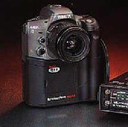

Predicted: binocular
Actual   : camera


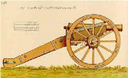

Predicted: pyramid
Actual   : cannon


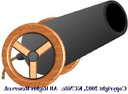

Predicted: mandolin
Actual   : cannon


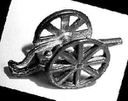

Predicted: binocular
Actual   : cannon


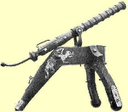

Predicted: revolver
Actual   : cannon


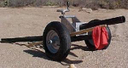

Predicted: kangaroo
Actual   : cannon


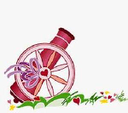

Predicted: wheelchair
Actual   : cannon


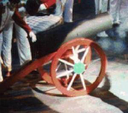

Predicted: wrench
Actual   : cannon


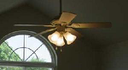

Predicted: mayfly
Actual   : ceiling_fan


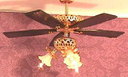

Predicted: saxophone
Actual   : ceiling_fan


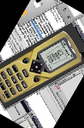

Predicted: bass
Actual   : cellphone


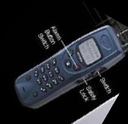

Predicted: nautilus
Actual   : cellphone


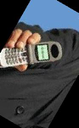

Predicted: electric_guitar
Actual   : cellphone


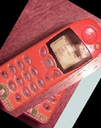

Predicted: lobster
Actual   : cellphone


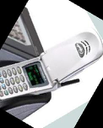

Predicted: laptop
Actual   : cellphone


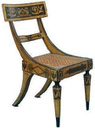

Predicted: scorpion
Actual   : chair


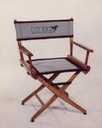

Predicted: stapler
Actual   : chair


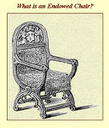

Predicted: nautilus
Actual   : chair


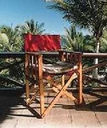

Predicted: gerenuk
Actual   : chair


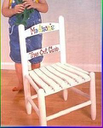

Predicted: binocular
Actual   : chair


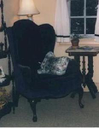

Predicted: laptop
Actual   : chair


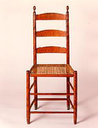

Predicted: windsor_chair
Actual   : chair


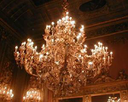

Predicted: hedgehog
Actual   : chandelier


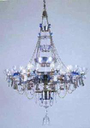

Predicted: crocodile
Actual   : chandelier


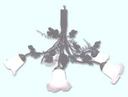

Predicted: stegosaurus
Actual   : chandelier


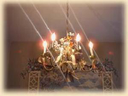

Predicted: ferry
Actual   : chandelier


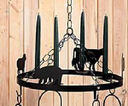

Predicted: bonsai
Actual   : chandelier


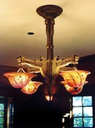

Predicted: mandolin
Actual   : chandelier


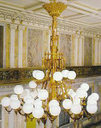

Predicted: brontosaurus
Actual   : chandelier


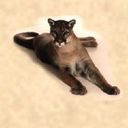

Predicted: revolver
Actual   : cougar_body


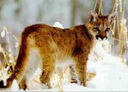

Predicted: bass
Actual   : cougar_body


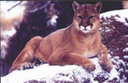

Predicted: electric_guitar
Actual   : cougar_body


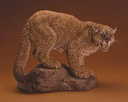

Predicted: platypus
Actual   : cougar_body


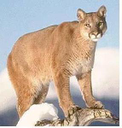

Predicted: platypus
Actual   : cougar_body


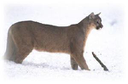

Predicted: brontosaurus
Actual   : cougar_body


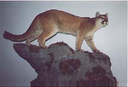

Predicted: dolphin
Actual   : cougar_body


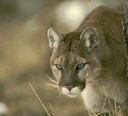

Predicted: crayfish
Actual   : cougar_face


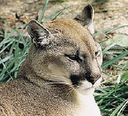

Predicted: beaver
Actual   : cougar_face


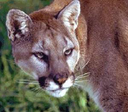

Predicted: cougar_body
Actual   : cougar_face


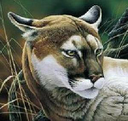

Predicted: beaver
Actual   : cougar_face


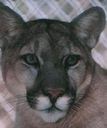

Predicted: elephant
Actual   : cougar_face


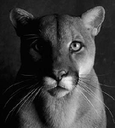

Predicted: cougar_body
Actual   : cougar_face


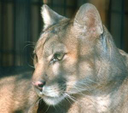

Predicted: beaver
Actual   : cougar_face


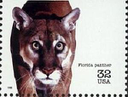

Predicted: electric_guitar
Actual   : cougar_face


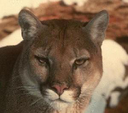

Predicted: bass
Actual   : cougar_face


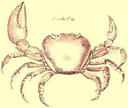

Predicted: mayfly
Actual   : crab


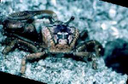

Predicted: hawksbill
Actual   : crab


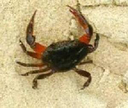

Predicted: starfish
Actual   : crab


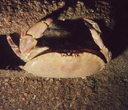

Predicted: umbrella
Actual   : crab


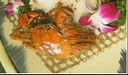

Predicted: bass
Actual   : crab


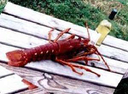

Predicted: lobster
Actual   : crayfish


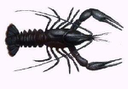

Predicted: scorpion
Actual   : crayfish


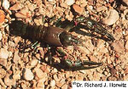

Predicted: ant
Actual   : crayfish


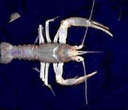

Predicted: chandelier
Actual   : crayfish


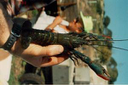

Predicted: bass
Actual   : crayfish


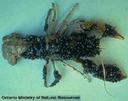

Predicted: crocodile
Actual   : crayfish


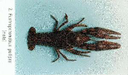

Predicted: crocodile
Actual   : crayfish


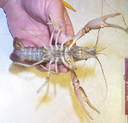

Predicted: ant
Actual   : crayfish


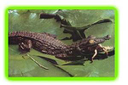

Predicted: airplanes
Actual   : crocodile


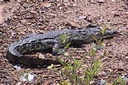

Predicted: hedgehog
Actual   : crocodile


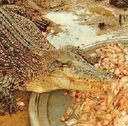

Predicted: crocodile_head
Actual   : crocodile


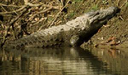

Predicted: wild_cat
Actual   : crocodile


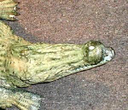

Predicted: mayfly
Actual   : crocodile_head


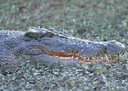

Predicted: pigeon
Actual   : crocodile_head


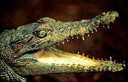

Predicted: hawksbill
Actual   : crocodile_head


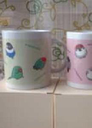

Predicted: water_lilly
Actual   : cup


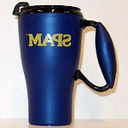

Predicted: binocular
Actual   : cup


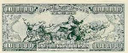

Predicted: wild_cat
Actual   : dollar_bill


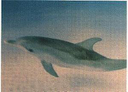

Predicted: pyramid
Actual   : dolphin


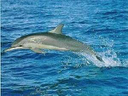

Predicted: pyramid
Actual   : dolphin


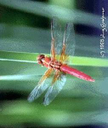

Predicted: mayfly
Actual   : dragonfly


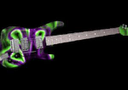

Predicted: dragonfly
Actual   : electric_guitar


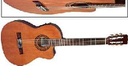

Predicted: mandolin
Actual   : electric_guitar


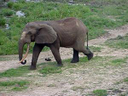

Predicted: rhino
Actual   : elephant


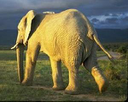

Predicted: rhino
Actual   : elephant


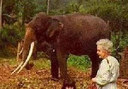

Predicted: kangaroo
Actual   : elephant


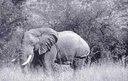

Predicted: rhino
Actual   : elephant


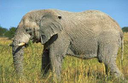

Predicted: pyramid
Actual   : elephant


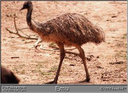

Predicted: umbrella
Actual   : emu


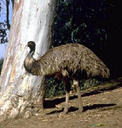

Predicted: crocodile
Actual   : emu


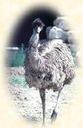

Predicted: llama
Actual   : emu


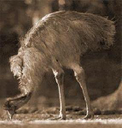

Predicted: rhino
Actual   : emu


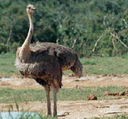

Predicted: crocodile
Actual   : emu


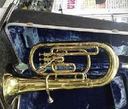

Predicted: menorah
Actual   : euphonium


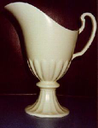

Predicted: mayfly
Actual   : ewer


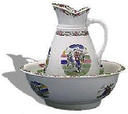

Predicted: headphone
Actual   : ewer


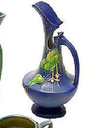

Predicted: headphone
Actual   : ewer


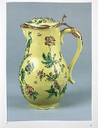

Predicted: watch
Actual   : ewer


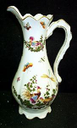

Predicted: cup
Actual   : ewer


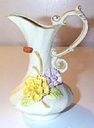

Predicted: chandelier
Actual   : ewer


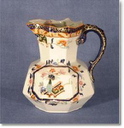

Predicted: cup
Actual   : ewer


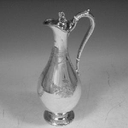

Predicted: pigeon
Actual   : ewer


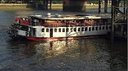

Predicted: laptop
Actual   : ferry


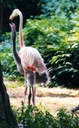

Predicted: ibis
Actual   : flamingo


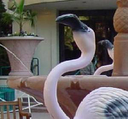

Predicted: anchor
Actual   : flamingo_head


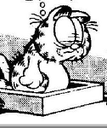

Predicted: snoopy
Actual   : garfield


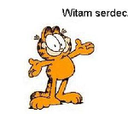

Predicted: snoopy
Actual   : garfield


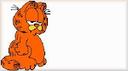

Predicted: metronome
Actual   : garfield


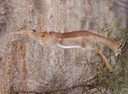

Predicted: emu
Actual   : gerenuk


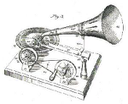

Predicted: cannon
Actual   : gramophone


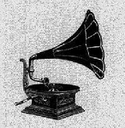

Predicted: scissors
Actual   : gramophone


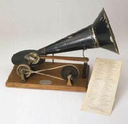

Predicted: stapler
Actual   : gramophone


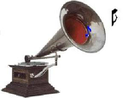

Predicted: binocular
Actual   : gramophone


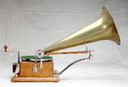

Predicted: pyramid
Actual   : gramophone


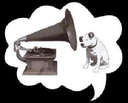

Predicted: binocular
Actual   : gramophone


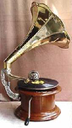

Predicted: stapler
Actual   : gramophone


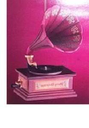

Predicted: stapler
Actual   : gramophone


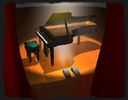

Predicted: lotus
Actual   : grand_piano


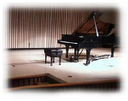

Predicted: stapler
Actual   : grand_piano


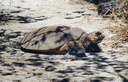

Predicted: scorpion
Actual   : hawksbill


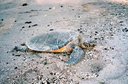

Predicted: crocodile
Actual   : hawksbill


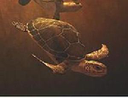

Predicted: butterfly
Actual   : hawksbill


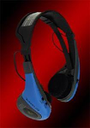

Predicted: cup
Actual   : headphone


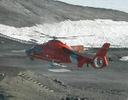

Predicted: dolphin
Actual   : helicopter


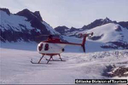

Predicted: octopus
Actual   : helicopter


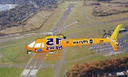

Predicted: hawksbill
Actual   : helicopter


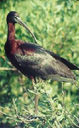

Predicted: pigeon
Actual   : ibis


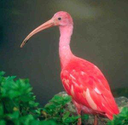

Predicted: flamingo_head
Actual   : ibis


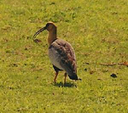

Predicted: scorpion
Actual   : ibis


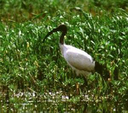

Predicted: pigeon
Actual   : ibis


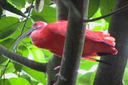

Predicted: lotus
Actual   : ibis


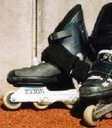

Predicted: wheelchair
Actual   : inline_skate


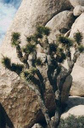

Predicted: crab
Actual   : joshua_tree


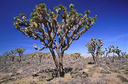

Predicted: wild_cat
Actual   : joshua_tree


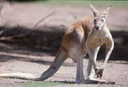

Predicted: cougar_body
Actual   : kangaroo


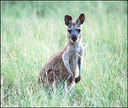

Predicted: Leopards
Actual   : kangaroo


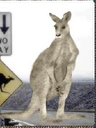

Predicted: brontosaurus
Actual   : kangaroo


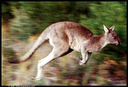

Predicted: ant
Actual   : kangaroo


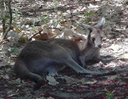

Predicted: beaver
Actual   : kangaroo


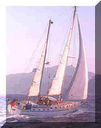

Predicted: schooner
Actual   : ketch


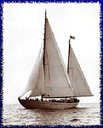

Predicted: schooner
Actual   : ketch


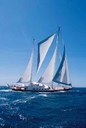

Predicted: schooner
Actual   : ketch


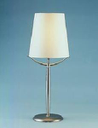

Predicted: umbrella
Actual   : lamp


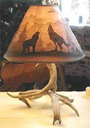

Predicted: buddha
Actual   : lamp


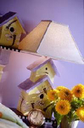

Predicted: helicopter
Actual   : lamp


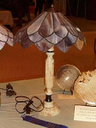

Predicted: anchor
Actual   : lamp


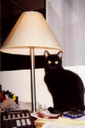

Predicted: umbrella
Actual   : lamp


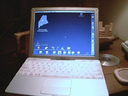

Predicted: cup
Actual   : laptop


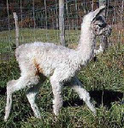

Predicted: pigeon
Actual   : llama


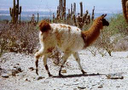

Predicted: wild_cat
Actual   : llama


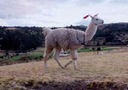

Predicted: helicopter
Actual   : llama


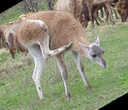

Predicted: emu
Actual   : llama


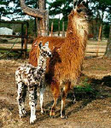

Predicted: emu
Actual   : llama


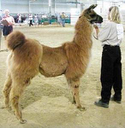

Predicted: elephant
Actual   : llama


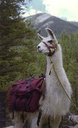

Predicted: ibis
Actual   : llama


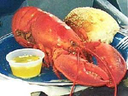

Predicted: butterfly
Actual   : lobster


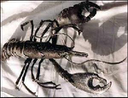

Predicted: crayfish
Actual   : lobster


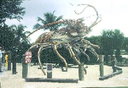

Predicted: bass
Actual   : lobster


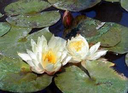

Predicted: water_lilly
Actual   : lotus


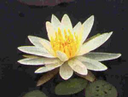

Predicted: water_lilly
Actual   : lotus


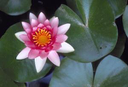

Predicted: water_lilly
Actual   : lotus


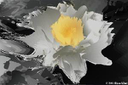

Predicted: water_lilly
Actual   : lotus


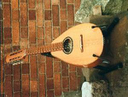

Predicted: umbrella
Actual   : mandolin


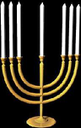

Predicted: ketch
Actual   : menorah


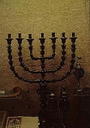

Predicted: scorpion
Actual   : menorah


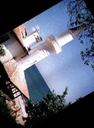

Predicted: elephant
Actual   : minaret


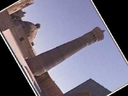

Predicted: mayfly
Actual   : minaret


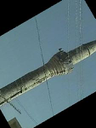

Predicted: mandolin
Actual   : minaret


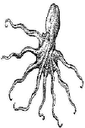

Predicted: dragonfly
Actual   : octopus


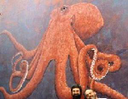

Predicted: ant
Actual   : octopus


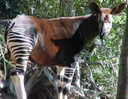

Predicted: Faces
Actual   : okapi


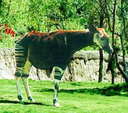

Predicted: ant
Actual   : okapi


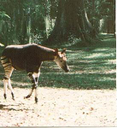

Predicted: mayfly
Actual   : okapi


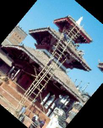

Predicted: accordion
Actual   : pagoda


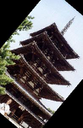

Predicted: accordion
Actual   : pagoda


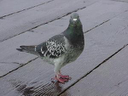

Predicted: umbrella
Actual   : pigeon


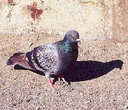

Predicted: beaver
Actual   : pigeon


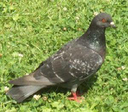

Predicted: crocodile_head
Actual   : pigeon


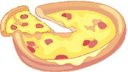

Predicted: cougar_face
Actual   : pizza


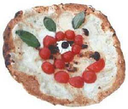

Predicted: crab
Actual   : pizza


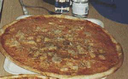

Predicted: beaver
Actual   : pizza


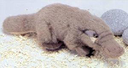

Predicted: brontosaurus
Actual   : platypus


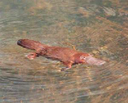

Predicted: starfish
Actual   : platypus


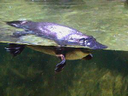

Predicted: mayfly
Actual   : platypus


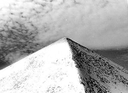

Predicted: crocodile_head
Actual   : pyramid


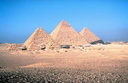

Predicted: ferry
Actual   : pyramid


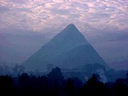

Predicted: dolphin
Actual   : pyramid


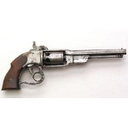

Predicted: wrench
Actual   : revolver


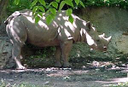

Predicted: schooner
Actual   : rhino


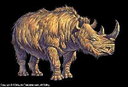

Predicted: wild_cat
Actual   : rhino


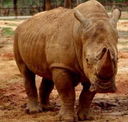

Predicted: elephant
Actual   : rhino


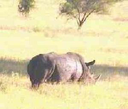

Predicted: brontosaurus
Actual   : rhino


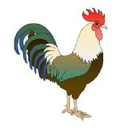

Predicted: headphone
Actual   : rooster


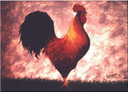

Predicted: soccer_ball
Actual   : rooster


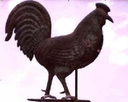

Predicted: brontosaurus
Actual   : rooster


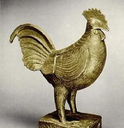

Predicted: bass
Actual   : rooster


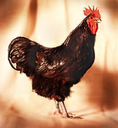

Predicted: mandolin
Actual   : rooster


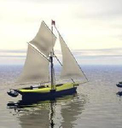

Predicted: ketch
Actual   : schooner


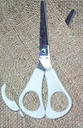

Predicted: ibis
Actual   : scissors


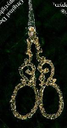

Predicted: mandolin
Actual   : scissors


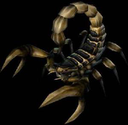

Predicted: ant
Actual   : scorpion


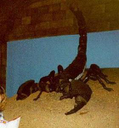

Predicted: rhino
Actual   : scorpion


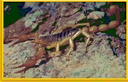

Predicted: crayfish
Actual   : scorpion


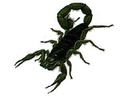

Predicted: headphone
Actual   : scorpion


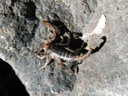

Predicted: crocodile
Actual   : scorpion


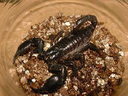

Predicted: hedgehog
Actual   : scorpion


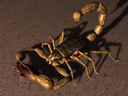

Predicted: chandelier
Actual   : scorpion


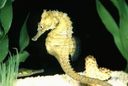

Predicted: mayfly
Actual   : sea_horse


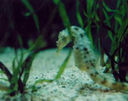

Predicted: crocodile_head
Actual   : sea_horse


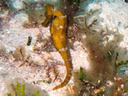

Predicted: crayfish
Actual   : sea_horse


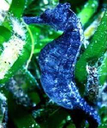

Predicted: hawksbill
Actual   : sea_horse


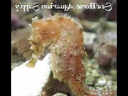

Predicted: bass
Actual   : sea_horse


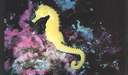

Predicted: crocodile
Actual   : sea_horse


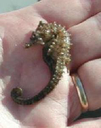

Predicted: mayfly
Actual   : sea_horse


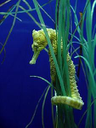

Predicted: mayfly
Actual   : sea_horse


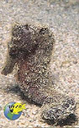

Predicted: hedgehog
Actual   : sea_horse


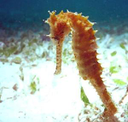

Predicted: octopus
Actual   : sea_horse


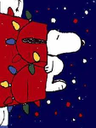

Predicted: wheelchair
Actual   : snoopy


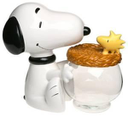

Predicted: lotus
Actual   : snoopy


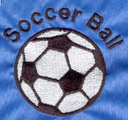

Predicted: rhino
Actual   : soccer_ball


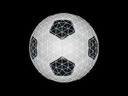

Predicted: yin_yang
Actual   : soccer_ball


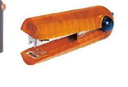

Predicted: airplanes
Actual   : stapler


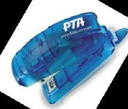

Predicted: cellphone
Actual   : stapler


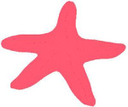

Predicted: wrench
Actual   : starfish


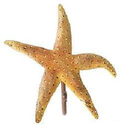

Predicted: dragonfly
Actual   : starfish


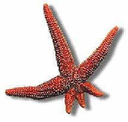

Predicted: mayfly
Actual   : starfish


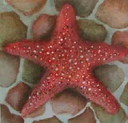

Predicted: hedgehog
Actual   : starfish


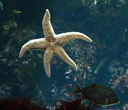

Predicted: mandolin
Actual   : starfish


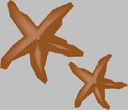

Predicted: scissors
Actual   : starfish


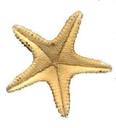

Predicted: dragonfly
Actual   : starfish


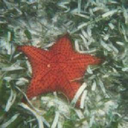

Predicted: ibis
Actual   : starfish


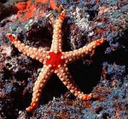

Predicted: okapi
Actual   : starfish


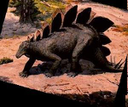

Predicted: beaver
Actual   : stegosaurus


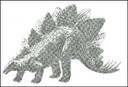

Predicted: hedgehog
Actual   : stegosaurus


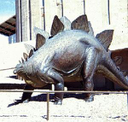

Predicted: helicopter
Actual   : stegosaurus


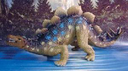

Predicted: crocodile
Actual   : stegosaurus


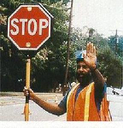

Predicted: ant
Actual   : stop_sign


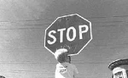

Predicted: windsor_chair
Actual   : stop_sign


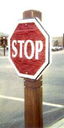

Predicted: barrel
Actual   : stop_sign


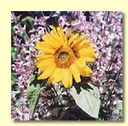

Predicted: wild_cat
Actual   : sunflower


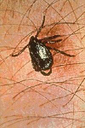

Predicted: scorpion
Actual   : tick


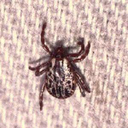

Predicted: scorpion
Actual   : tick


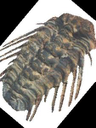

Predicted: lobster
Actual   : trilobite


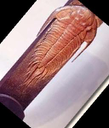

Predicted: umbrella
Actual   : trilobite


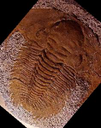

Predicted: hedgehog
Actual   : trilobite


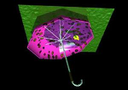

Predicted: brain
Actual   : umbrella


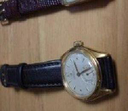

Predicted: mayfly
Actual   : watch


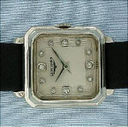

Predicted: ketch
Actual   : watch


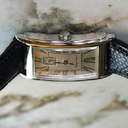

Predicted: laptop
Actual   : watch


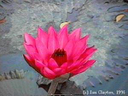

Predicted: lotus
Actual   : water_lilly


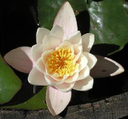

Predicted: euphonium
Actual   : water_lilly


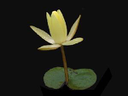

Predicted: lotus
Actual   : water_lilly


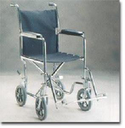

Predicted: chandelier
Actual   : wheelchair


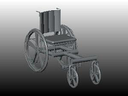

Predicted: revolver
Actual   : wheelchair


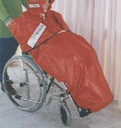

Predicted: nautilus
Actual   : wheelchair


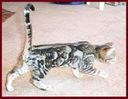

Predicted: ant
Actual   : wild_cat


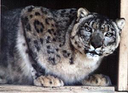

Predicted: hawksbill
Actual   : wild_cat


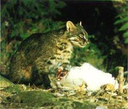

Predicted: mayfly
Actual   : wild_cat


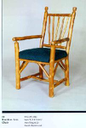

Predicted: chandelier
Actual   : windsor_chair


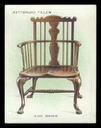

Predicted: menorah
Actual   : windsor_chair


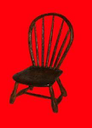

Predicted: lamp
Actual   : windsor_chair


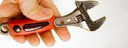

Predicted: electric_guitar
Actual   : wrench


In [30]:
def plot_incorrect_images(predicted, actual):
    for i, (_actual, _predicted) in enumerate(zip(actual, predicted)):
        if not _actual == _predicted:
            image_file_name = val_generator.filenames[i]
            im = Image.open(os.path.join(val_data_dir, image_file_name))
            im.thumbnail((128, 128), Image.ANTIALIAS)
            display(im)
            print('Predicted: {0}\nActual   : {1}'.format(key_to_label[_predicted], key_to_label[_actual]))
plot_incorrect_images(v19_predicted, actual)